In [1]:
path = "/content/drive/MyDrive/Colab Notebooks/MIMIC3.csv"

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


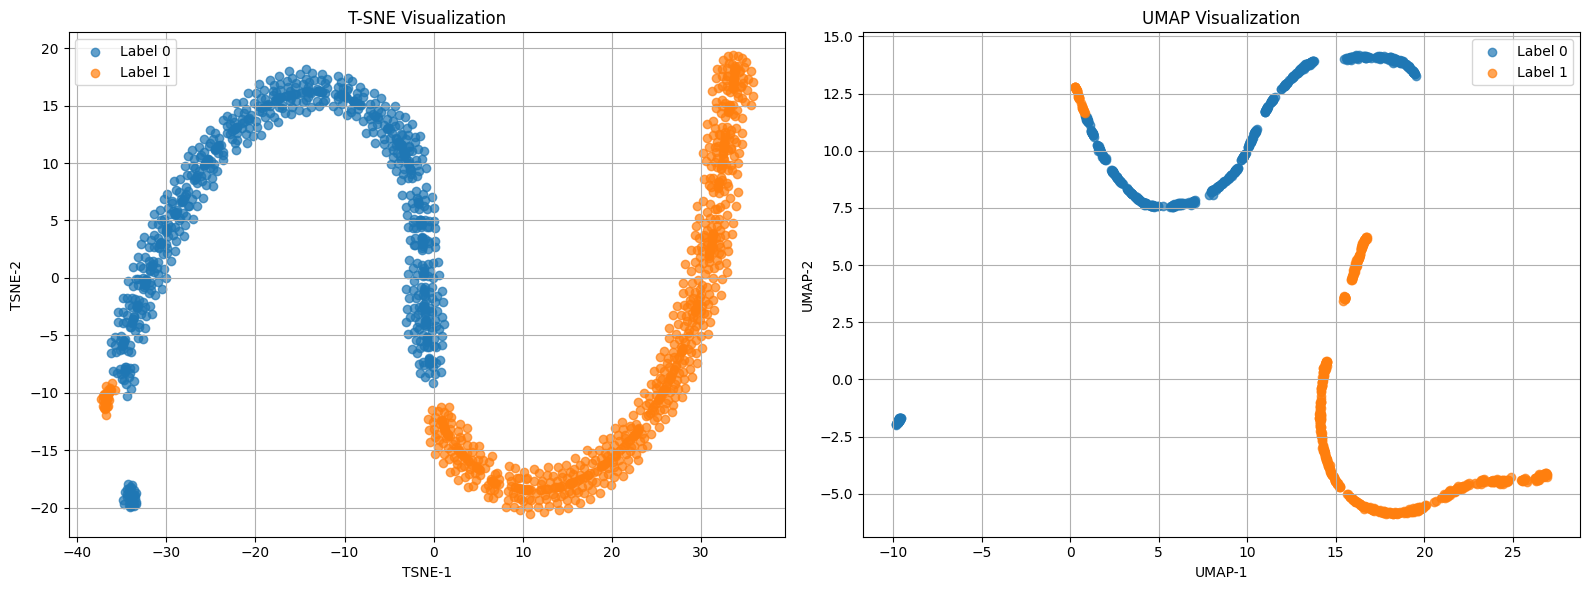

In [3]:
# -------------------- Import --------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

# -------------------- 1. 데이터 불러오기 --------------------
df = pd.read_csv(path)

# -------------------- 2. X, y 분리 --------------------
# 'Label' 컬럼은 y로, 나머지 feature들은 X로 사용
X = df.drop(columns=['Label']).values
y = df['Label'].values

# -------------------- 3. T-SNE 변환 --------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# -------------------- 4. UMAP 변환 --------------------
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)

# -------------------- 5. 시각화 --------------------
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# (1) T-SNE
unique_labels = np.unique(y)
for label in unique_labels:
    idx = (y == label)
    axs[0].scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=f'Label {label}', alpha=0.7)
axs[0].set_title('T-SNE Visualization')
axs[0].set_xlabel('TSNE-1')
axs[0].set_ylabel('TSNE-2')
axs[0].legend()
axs[0].grid(True)

# (2) UMAP
for label in unique_labels:
    idx = (y == label)
    axs[1].scatter(X_umap[idx, 0], X_umap[idx, 1], label=f'Label {label}', alpha=0.7)
axs[1].set_title('UMAP Visualization')
axs[1].set_xlabel('UMAP-1')
axs[1].set_ylabel('UMAP-2')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()



In [5]:
# -------------------- Import --------------------
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random

# -------------------- Seed 고정 --------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

# -------------------- 1. 간단한 Augmentation --------------------
def jitter(x, sigma=0.01):
    return x + sigma * np.random.randn(*x.shape)

def scaling(x, sigma=0.05):
    return x * np.random.normal(1.0, sigma)

class PPGAugmentation:
    def __init__(self):
        pass
    def __call__(self, x):
        x = jitter(x)
        x = scaling(x)
        return x

# -------------------- 2. Encoder, Projector 정의 --------------------
class CNNEncoder(nn.Module):
    def __init__(self, emb_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, emb_dim, kernel_size=5, padding=2),
            nn.BatchNorm1d(emb_dim), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(emb_dim, emb_dim, kernel_size=5, padding=2),
            nn.BatchNorm1d(emb_dim), nn.ReLU(), nn.AdaptiveAvgPool1d(1)
        )
    def forward(self, x):
        x = self.net(x)
        return x.squeeze(-1)

class ProjHead(nn.Module):
    def __init__(self, emb_dim=64, proj_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, proj_dim)
        )
    def forward(self, x):
        return F.normalize(self.net(x), dim=1)

class DualEncoderSSL(nn.Module):
    def __init__(self, emb_dim=64, proj_dim=64):
        super().__init__()
        self.encoder = CNNEncoder(emb_dim)
        self.projector = ProjHead(emb_dim, proj_dim)
    def forward(self, v1, v2):
        h1 = self.encoder(v1)
        h2 = self.encoder(v2)
        return self.projector(h1), self.projector(h2)

# -------------------- 3. NT-Xent Loss --------------------
def nt_xent(z1, z2, temperature=0.5):
    B = z1.size(0)
    z = torch.cat([z1, z2], dim=0)
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / temperature
    mask = ~torch.eye(2*B, device=z.device, dtype=torch.bool)
    sim_neg = sim.masked_select(mask).view(2*B, -1)
    pos = torch.cat([sim.diagonal(B), sim.diagonal(-B)]).view(2*B, 1)
    logits = torch.cat([pos, sim_neg], dim=1)
    return F.cross_entropy(logits, torch.zeros(2*B, dtype=torch.long, device=z.device))

# -------------------- 4. Dataset 정의 --------------------
class SSLDataset(Dataset):
    def __init__(self, segments, transform):
        self.X = segments
        self.transform = transform
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        aug1 = self.transform(x)
        aug2 = self.transform(x)
        return torch.from_numpy(aug1[None, :]).float(), torch.from_numpy(aug2[None, :]).float()

class ClassifierDataset(Dataset):
    def __init__(self, segments, labels):
        self.X = segments
        self.y = labels
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][None, :]).float(), torch.tensor(self.y[idx]).long()

# -------------------- 5. Classifier 모델 --------------------
class SimpleClassifier(nn.Module):
    def __init__(self, encoder, num_classes=2):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(encoder.net[-3].num_features, num_classes)
    def forward(self, x):
        h = self.encoder(x)
        return self.fc(h)

# -------------------- 6. Main --------------------
if __name__ == "__main__":

    # ----------- 데이터 로드 및 전처리 -----------

    df = pd.read_csv(path)
    signal_cols = [c for c in df.columns if c != 'Label']
    signals = df[signal_cols].values.astype(np.float32)
    labels  = df['Label'].values.astype(np.int64)

    window_size, stride = 500, 250
    segments, seg_labels, groups = [], [], []
    for subj_id, (sig, lab) in enumerate(zip(signals, labels), start=1):
        for start in range(0, len(sig)-window_size+1, stride):
            segments.append(sig[start:start+window_size])
            seg_labels.append(lab)
            groups.append(subj_id)
    segments = np.stack(segments)
    seg_labels = np.array(seg_labels)
    groups = np.array(groups)

    # ----------- SSL Pretraining -----------
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ssl_dataset = SSLDataset(segments, PPGAugmentation())
    ssl_loader = DataLoader(ssl_dataset, batch_size=64, shuffle=True)

    model_ssl = DualEncoderSSL().to(device)
    optimizer_ssl = torch.optim.Adam(model_ssl.parameters(), lr=1e-3)

    for epoch in range(1, 21):
        model_ssl.train()
        total_loss = 0
        for v1, v2 in ssl_loader:
            v1, v2 = v1.to(device), v2.to(device)
            z1, z2 = model_ssl(v1, v2)
            loss = nt_xent(z1, z2)
            optimizer_ssl.zero_grad()
            loss.backward()
            optimizer_ssl.step()
            total_loss += loss.item()
        print(f"[SSL] Epoch {epoch:02d} — Loss: {total_loss/len(ssl_loader):.4f}")

    # ----------- 랜덤하게 Subject 10조각 나누기 -----------
    unique_subjects = np.unique(groups)
    np.random.shuffle(unique_subjects)  # 랜덤 섞기
    folds = np.array_split(unique_subjects, 10)  # 10조각

    # Encoder Freeze
    encoder = model_ssl.encoder
    for p in encoder.parameters():
        p.requires_grad = False

    # ----------- Fine-tuning by Random Subject Split -----------
    for fold_idx, test_subjects in enumerate(folds, start=1):
        print(f"\n=== Fold {fold_idx} ===")
        is_test = np.isin(groups, test_subjects)

        X_tr, y_tr = segments[~is_test], seg_labels[~is_test]
        X_te, y_te = segments[is_test], seg_labels[is_test]

        train_ds = ClassifierDataset(X_tr, y_tr)
        test_ds = ClassifierDataset(X_te, y_te)
        train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

        model = SimpleClassifier(encoder).to(device)
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(1, 11):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()

        model.eval()
        preds, truths = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                out = model(xb).argmax(dim=1).cpu().numpy()
                preds.extend(out)
                truths.extend(yb.numpy())

        acc = accuracy_score(truths, preds)
        print(f"Fold {fold_idx} Accuracy: {acc:.4f}")



[SSL] Epoch 01 — Loss: 3.3330
[SSL] Epoch 02 — Loss: 3.1520
[SSL] Epoch 03 — Loss: 3.1165
[SSL] Epoch 04 — Loss: 3.1029
[SSL] Epoch 05 — Loss: 3.0863
[SSL] Epoch 06 — Loss: 3.0782
[SSL] Epoch 07 — Loss: 3.0719
[SSL] Epoch 08 — Loss: 3.0634
[SSL] Epoch 09 — Loss: 3.0596
[SSL] Epoch 10 — Loss: 3.0540
[SSL] Epoch 11 — Loss: 3.0492
[SSL] Epoch 12 — Loss: 3.0458
[SSL] Epoch 13 — Loss: 3.0405
[SSL] Epoch 14 — Loss: 3.0364
[SSL] Epoch 15 — Loss: 3.0353
[SSL] Epoch 16 — Loss: 3.0332
[SSL] Epoch 17 — Loss: 3.0312
[SSL] Epoch 18 — Loss: 3.0304
[SSL] Epoch 19 — Loss: 3.0264
[SSL] Epoch 20 — Loss: 3.0286

=== Fold 1 ===
Fold 1 Accuracy: 0.9961

=== Fold 2 ===
Fold 2 Accuracy: 0.9954

=== Fold 3 ===
Fold 3 Accuracy: 0.9927

=== Fold 4 ===
Fold 4 Accuracy: 0.9940

=== Fold 5 ===
Fold 5 Accuracy: 0.9980

=== Fold 6 ===
Fold 6 Accuracy: 0.9927

=== Fold 7 ===
Fold 7 Accuracy: 0.9901

=== Fold 8 ===
Fold 8 Accuracy: 0.9874

=== Fold 9 ===
Fold 9 Accuracy: 0.9901

=== Fold 10 ===
Fold 10 Accuracy: 0.989

In [7]:
#---------------------------------------
# Raw 1D 입력
# → Dual Encoder SSL (CNN + Transformer)
#  → Freeze 후
#  → Dilated TCN Stack (causal dilation)
#  → Transformer Encoder
#  → Attention Fusion (두 branch 출력 융합)
#  → Linear Layer → Softmax 분류
#---------------------------------------

# -------------------- Import --------------------
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import random
import os

# -------------------- Seed 고정 --------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

# -------------------- Augmentation --------------------
def jitter(x, sigma=0.01):
    return x + sigma * np.random.randn(*x.shape)

def scaling(x, sigma=0.05):
    return x * np.random.normal(1.0, sigma)

class PPGAugmentation:
    def __init__(self):
        pass
    def __call__(self, x):
        x = jitter(x)
        x = scaling(x)
        return x

# -------------------- Dataset --------------------
class SSLDataset(Dataset):
    def __init__(self, segments, transform):
        self.X = segments
        self.transform = transform
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        aug1 = self.transform(x)
        aug2 = self.transform(x)
        return torch.from_numpy(aug1[None, :]).float(), torch.from_numpy(aug2[None, :]).float()

class ClassifierDataset(Dataset):
    def __init__(self, segments, labels):
        self.X = segments
        self.y = labels
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][None, :]).float(), torch.tensor(self.y[idx]).long()

# -------------------- Dual Encoder --------------------
class CNNEncoder(nn.Module):
    def __init__(self, emb_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, emb_dim, kernel_size=5, padding=2),
            nn.BatchNorm1d(emb_dim), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(emb_dim, emb_dim, kernel_size=5, padding=2),
            nn.BatchNorm1d(emb_dim), nn.ReLU(), nn.AdaptiveAvgPool1d(1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

class TransformerEncoder(nn.Module):
    def __init__(self, emb_dim=64, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Conv1d(1, emb_dim, kernel_size=1)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    def forward(self, x):
        x = self.input_proj(x).permute(0,2,1)
        return self.transformer(x).mean(dim=1)

class ProjHead(nn.Module):
    def __init__(self, emb_dim=64, proj_dim=64):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(emb_dim, emb_dim), nn.ReLU(), nn.Linear(emb_dim, proj_dim))
    def forward(self, x):
        return F.normalize(self.net(x), dim=1)

class DualEncoderSSL(nn.Module):
    def __init__(self, emb_dim=64, proj_dim=64):
        super().__init__()
        self.cnn_enc = CNNEncoder(emb_dim)
        self.trans_enc = TransformerEncoder(emb_dim)
        self.proj_cnn = ProjHead(emb_dim, proj_dim)
        self.proj_trans = ProjHead(emb_dim, proj_dim)
    def forward(self, v1, v2):
        return self.proj_cnn(self.cnn_enc(v1)), self.proj_trans(self.trans_enc(v2))

# -------------------- NT-Xent Loss --------------------
def nt_xent(z1, z2, temperature=0.5):
    B = z1.size(0)
    z = torch.cat([z1, z2], dim=0)
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / temperature
    mask = ~torch.eye(2*B, device=z.device, dtype=torch.bool)
    sim_neg = sim.masked_select(mask).view(2*B, -1)
    pos = torch.cat([sim.diagonal(B), sim.diagonal(-B)]).view(2*B, 1)
    logits = torch.cat([pos, sim_neg], dim=1)
    return F.cross_entropy(logits, torch.zeros(2*B, dtype=torch.long, device=z.device))

# -------------------- Real TCN + Transformer Classifier --------------------
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=(kernel_size-1)*dilation//2, dilation=dilation)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class DilatedTCNStack(nn.Module):
    def __init__(self, emb_dim, num_layers=4, kernel_size=3):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layers.append(TCNBlock(emb_dim, emb_dim, kernel_size=kernel_size, dilation=2**i))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, nhead=4, num_layers=1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    def forward(self, x):
        return self.transformer(x)

class AttentionFusion(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.query = nn.Linear(emb_dim, emb_dim)
        self.key = nn.Linear(emb_dim, emb_dim)
        self.value = nn.Linear(emb_dim, emb_dim)
    def forward(self, h1, h2):
        h_cat = torch.stack([h1, h2], dim=1)
        q = self.query(h_cat)
        k = self.key(h_cat)
        v = self.value(h_cat)
        attn_weights = torch.softmax((q @ k.transpose(-2, -1)) / (h1.size(-1) ** 0.5), dim=-1)
        fused = (attn_weights @ v).sum(dim=1)
        return fused

class SSLClassifier(nn.Module):
    def __init__(self, encoder, emb_dim=64, num_classes=2):
        super().__init__()
        self.encoder = encoder
        self.tcn = DilatedTCNStack(emb_dim)
        self.transformer = TransformerBlock(emb_dim)
        self.fusion = AttentionFusion(emb_dim)
        self.classifier = nn.Sequential(
            nn.Linear(emb_dim, emb_dim), nn.ReLU(), nn.Linear(emb_dim, num_classes)
        )
    def forward(self, x):
        h = self.encoder(x).unsqueeze(1).repeat(1, x.shape[-1], 1)
        h = h.permute(0, 2, 1)
        h_tcn = self.tcn(h).permute(0, 2, 1)
        h_trans = self.transformer(h_tcn)
        h1_pooled = h_tcn.mean(dim=1)
        h2_pooled = h_trans.mean(dim=1)
        fused = self.fusion(h1_pooled, h2_pooled)
        return self.classifier(fused)

# -------------------- Main --------------------
if __name__ == "__main__":

    signals = df[[c for c in df.columns if c != 'Label']].values.astype(np.float32)
    labels = df['Label'].values.astype(np.int64)

    window_size, stride = 500, 250
    segments, seg_labels, groups = [], [], []
    for subj_id, (sig, lab) in enumerate(zip(signals, labels), start=1):
        for start in range(0, len(sig)-window_size+1, stride):
            segments.append(sig[start:start+window_size])
            seg_labels.append(lab)
            groups.append(subj_id)
    segments = np.stack(segments)
    seg_labels = np.array(seg_labels)
    groups = np.array(groups)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    ssl_dataset = SSLDataset(segments, PPGAugmentation())
    ssl_loader = DataLoader(ssl_dataset, batch_size=64, shuffle=True)

    model_ssl = DualEncoderSSL().to(device)
    optimizer_ssl = torch.optim.Adam(model_ssl.parameters(), lr=1e-3)

    for epoch in range(1, 21):
        model_ssl.train(); total_loss = 0
        for v1, v2 in ssl_loader:
            v1, v2 = v1.to(device), v2.to(device)
            z1, z2 = model_ssl(v1, v2)
            loss = nt_xent(z1, z2)
            optimizer_ssl.zero_grad(); loss.backward(); optimizer_ssl.step()
            total_loss += loss.item()
        print(f"[SSL] Epoch {epoch:02d} — Loss: {total_loss/len(ssl_loader):.4f}")

    encoder = model_ssl.cnn_enc
    for p in encoder.parameters():
        p.requires_grad = False

    unique_subjects = np.unique(groups)
    np.random.shuffle(unique_subjects)
    folds = np.array_split(unique_subjects, 10)

    for fold_idx, test_subjects in enumerate(folds, start=1):
        is_test = np.isin(groups, test_subjects)
        X_tr, y_tr = segments[~is_test], seg_labels[~is_test]
        X_te, y_te = segments[is_test], seg_labels[is_test]

        train_loader = DataLoader(ClassifierDataset(X_tr, y_tr), batch_size=64, shuffle=True)
        test_loader = DataLoader(ClassifierDataset(X_te, y_te), batch_size=64, shuffle=False)

        model = SSLClassifier(encoder).to(device)
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(1, 11):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()

        model.eval(); preds, truths = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                out = model(xb).argmax(dim=1).cpu().numpy()
                preds.extend(out)
                truths.extend(yb.numpy())

        acc = accuracy_score(truths, preds)
        print(f"Fold {fold_idx} Accuracy: {acc:.4f}")

[SSL] Epoch 01 — Loss: 3.9033
[SSL] Epoch 02 — Loss: 3.4994
[SSL] Epoch 03 — Loss: 3.4414
[SSL] Epoch 04 — Loss: 3.4268
[SSL] Epoch 05 — Loss: 3.3979
[SSL] Epoch 06 — Loss: 3.3904
[SSL] Epoch 07 — Loss: 3.3783
[SSL] Epoch 08 — Loss: 3.3680
[SSL] Epoch 09 — Loss: 3.3652
[SSL] Epoch 10 — Loss: 3.3544
[SSL] Epoch 11 — Loss: 3.3484
[SSL] Epoch 12 — Loss: 3.3543
[SSL] Epoch 13 — Loss: 3.3529
[SSL] Epoch 14 — Loss: 3.3374
[SSL] Epoch 15 — Loss: 3.3297
[SSL] Epoch 16 — Loss: 3.3252
[SSL] Epoch 17 — Loss: 3.3300
[SSL] Epoch 18 — Loss: 3.3146
[SSL] Epoch 19 — Loss: 3.3139
[SSL] Epoch 20 — Loss: 3.3281
Fold 1 Accuracy: 0.9967
Fold 2 Accuracy: 0.9974
Fold 3 Accuracy: 0.9914
Fold 4 Accuracy: 0.9974
Fold 5 Accuracy: 0.9927
Fold 6 Accuracy: 0.9980
Fold 7 Accuracy: 0.9960
Fold 8 Accuracy: 0.9967
Fold 9 Accuracy: 0.9940
Fold 10 Accuracy: 0.9980


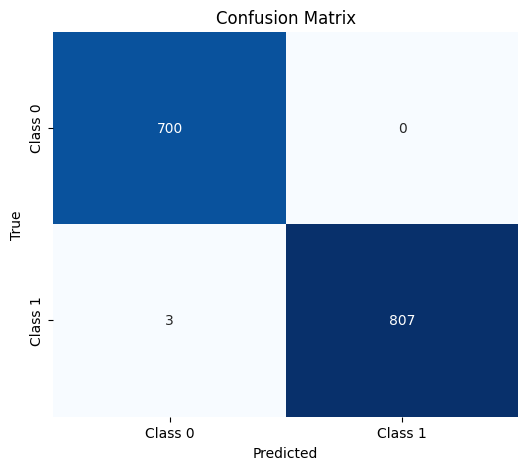

In [8]:
# -------------------- Confusion Matrix --------------------
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# After your test loop, where you have 'truths' and 'preds'

# Compute confusion matrix
cm = confusion_matrix(truths, preds)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Normal', 'Hypertension'], yticklabels=['Normal', 'Hypertension'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


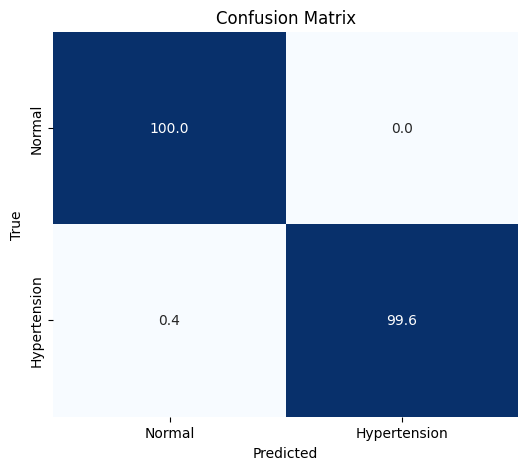

In [13]:
# -------------------- Confusion Matrix (Percentages) --------------------
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# After your test loop, where you have 'truths' and 'preds'

# Compute confusion matrix
cm = confusion_matrix(truths, preds)

# Normalize the confusion matrix to get percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues", cbar=False,
            xticklabels=['Normal', 'Hypertension'], yticklabels=['Normal', 'Hypertension'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


F1 Score: 0.9981
Precision: 1.0000
Recall: 0.9963
ROC AUC: 0.9981


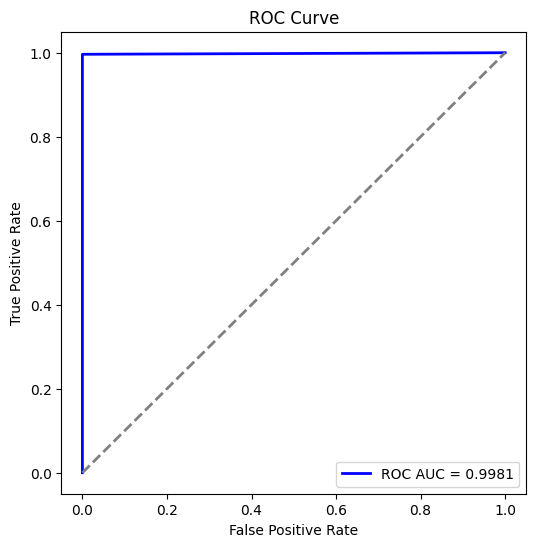

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Compute F1, Precision, Recall for binary classification
f1 = f1_score(truths, preds)
precision = precision_score(truths, preds)
recall = recall_score(truths, preds)

# Compute ROC-AUC score
roc_auc = roc_auc_score(truths, preds)

# Compute Precision-Recall AUC score
precision_auc = precision_recall_curve(truths, preds)

# Print the metrics
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ------------------ Plotting -------------------

# 1. ROC Curve
fpr, tpr, _ = roc_curve(truths, preds)
plt.figure(figsize=(6, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")




In [21]:
path = "/content/drive/MyDrive/Colab Notebooks/combined_dataset.xlsx"

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [10 11 12]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


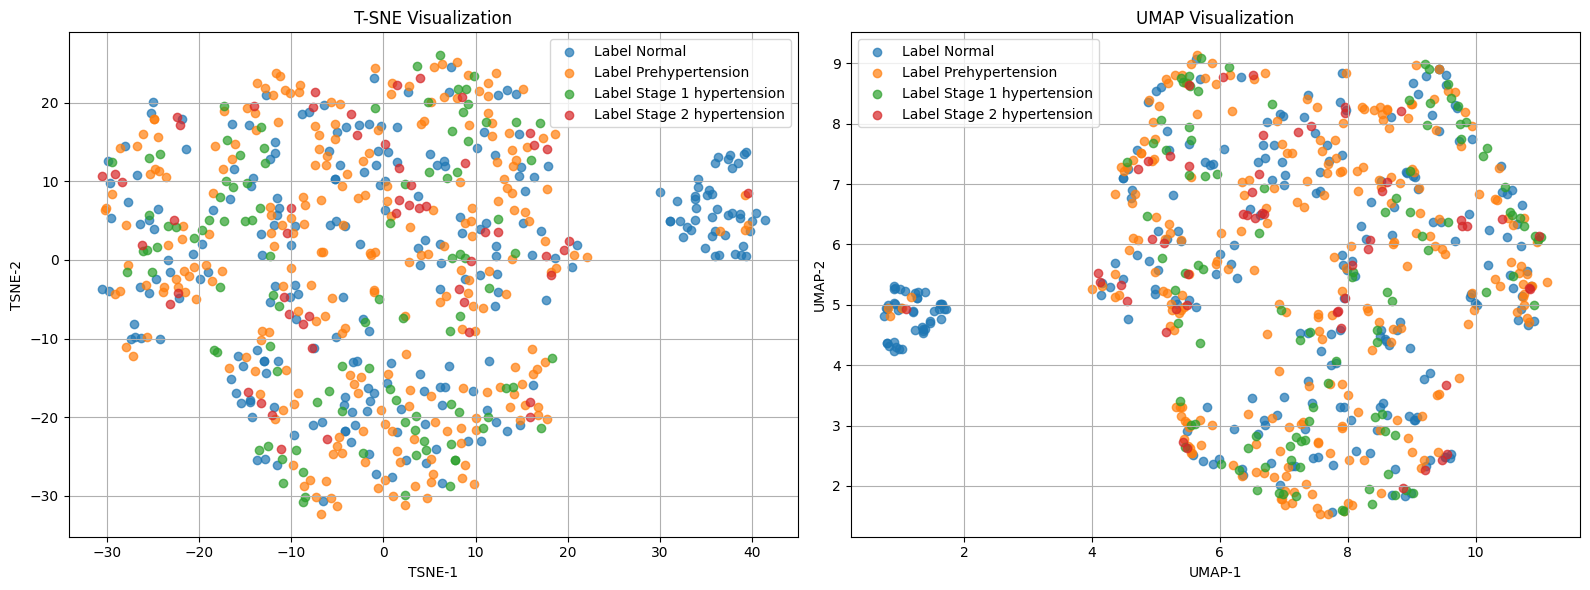

In [30]:
# -------------------- Import --------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from sklearn.impute import SimpleImputer

# -------------------- 1. 데이터 불러오기 --------------------
df = pd.read_excel(path)

# -------------------- 2. X, y 분리 --------------------
# 'Sex(M/F)' 컬럼을 0과 1로 변환
df['Sex(M/F)'] = df['Sex(M/F)'].map({'Male': 0, 'Female': 1})

# 'Diabetes' 컬럼을 'Yes'는 1로, 'No'는 0으로 변환
df['Diabetes'] = df['Diabetes'].map({'Yes': 1, 'No': 0})

# 'cerebral infarction'과 'cerebrovascular disease' 컬럼도 필요하다면 수치형으로 변환
df['cerebral infarction'] = df['cerebral infarction'].map({'Yes': 1, 'No': 0})
df['cerebrovascular disease'] = df['cerebrovascular disease'].map({'Yes': 1, 'No': 0})

# 삭제할 컬럼 리스트
columns_to_drop = [
    'Num.', 'subject_ID', 'Age(year)', 'Height(cm)', 'Weight(kg)',
    'Systolic Blood Pressure(mmHg)', 'Diastolic Blood Pressure(mmHg)', 'Heart Rate(b/m)',
    'BMI(kg/m^2)', 'cerebral infarction', 'cerebrovascular disease'
]

# 해당 컬럼들을 드롭하고 나머지 데이터를 X에 저장
X = df.drop(columns=columns_to_drop)

# 15번째부터 2100번째까지의 데이터로 X 재정의
X = df.iloc[14:2100].drop(columns=['Hypertension']).values
y = df['Hypertension'].values[14:2100]

# -------------------- 3. 결측치 처리 --------------------
# 결측치를 평균으로 대체
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# -------------------- 4. T-SNE 변환 --------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# -------------------- 5. UMAP 변환 --------------------
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)

# -------------------- 6. 시각화 --------------------
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# (1) T-SNE
unique_labels = np.unique(y)
for label in unique_labels:
    idx = (y == label)
    axs[0].scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=f'Label {label}', alpha=0.7)
axs[0].set_title('T-SNE Visualization')
axs[0].set_xlabel('TSNE-1')
axs[0].set_ylabel('TSNE-2')
axs[0].legend()
axs[0].grid(True)

# (2) UMAP
for label in unique_labels:
    idx = (y == label)
    axs[1].scatter(X_umap[idx, 0], X_umap[idx, 1], label=f'Label {label}', alpha=0.7)
axs[1].set_title('UMAP Visualization')
axs[1].set_xlabel('UMAP-1')
axs[1].set_ylabel('UMAP-2')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
